# Problématique

<h3> Prédire le mot dans l'image </h3>

- Création de dataset Tensorflow pour faire des traitements par lots et pouvoir utiliser toutes les images de la base pour le modele
- Modèle Deep learning : RNN
- Évaluation du modèle : ?


# Import

In [20]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl


In [24]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)

<module 'modele' from 'd:\\GitHub\\OCRpyMAN\\notebooks\\modele.py'>

# Chargement du dataframe

In [15]:
# initialisation des variables globales
rss.init()

In [16]:
# Chargement avec tensorflow et dataset par batch

dataset_train, dataset_test, y_test = ld_util.get_dataset()

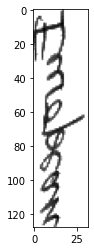

In [17]:
### TEST - TODELETE ###
# Visualisation du contenu du dataset créé au-dessus


from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
        
x, y = next(iter(dataset_train))
x[0].shape

tmp = x[0]
# tmp = tf.squeeze(tmp, axis=2)
# tmp = np.swapaxes(tmp, 0, 1)
# tmp = tmp.reshape(128,32)
plt.imshow(tmp , cmap='gray');  # .reshape(rss.img_size)


# Model RNN

### Création Modèle

In [23]:
model = mdl.create_modele()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 32, 32)       832       
                                                                 
 batch_normalization_10 (Bat  (None, 128, 32, 32)      128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128, 32, 32)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 16, 64)        51264     
                                                                 
 batch_normalization_11 (Bat  (None, 64, 16, 64)      

In [19]:

#pour stopper l'apprentissage si la loss n'évolue plus
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=mdl.CTCLoss(), optimizer=optimizer)
history = model.fit(
    dataset_train,
    validation_data=dataset_test,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ],
    epochs=10
)

Epoch 1/10
1274/1285 [============================>.] - ETA: 15s - loss: 10.8279

KeyboardInterrupt: 

In [ ]:
# Sauvegarde et/ou rechargement de l'history dans un pickle et du modele  : décommenter la partie voulue

#Sauvegarde historique
# with open('../pickle/history_propershape2.pickle', 'wb') as file_pi:
#      pickle.dump(history.history, file_pi)

#Rechargement historique
# with open('../pickle/history_propershape.pickle', "rb") as file_pi:
#     history = pickle.load(file_pi)


# Sauvegarde/Chargement du modele
model.save('ctc_model_fit_10')
model = tf.keras.models.load_model("ctc_model_fit_10", custom_objects={"CTCLoss": mdl.CTCLoss})

In [ ]:
# Affichage des courbes de perte

mdl.show_loss(history)

In [ ]:
# Apperçu du résultat avec quelque prédictions

y_pred = model.predict(dataset_test)
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
eval_data = list(zip(y_test, predicted_transcriptions))

eval_df = pd.DataFrame(data=np.array(eval_data), columns=['real', 'predicted'])
eval_df.head(10)

eval_df['cer'] = [ld_util.evaluate_character_level_accuracy(row.real, row.predicted) for index, row in eval_df.iterrows()]

print("Notre modèle a une précision par mot de", eval_df['cer'].mean(), ' pour ', eval_df.shape[0], ' mots.')

